## Ecommerce Recommendation System(Sequential + Content based) Using Transformers

### 1. MAIN OBJECTIVE  

- The main objective of this project is to build a **hybrid recommendation system** for an e-commerce platform, consisting of:  
  1. A **sequential recommendation system** that leverages the order of user interactions (views and purchases) to predict the next product a user is most likely to engage with.  
  2. **Content-based recommendation systems** that use product and brand information (brand, category, price) encoded with BERT embeddings to recommend items based on similarity.  

- Unlike traditional recommendation systems that rely only on static features (e.g., demographics or product popularity), this project combines **sequential modeling** and **content-based approaches** to provide both **personalized** and **alternative product/brand** suggestions.  

##### BUSINESS VALUE  

The recommendation system brings multiple layers of value to the e-commerce platform:  

- **Sequential Recommendation System:**  
  - Learns from the **order of user interactions** (views, purchases) to anticipate the next likely product.  
  - Provides **personalized recommendations** that increase user engagement.  
  - Boosts **conversion rates** by surfacing products users are most likely to buy.  

- **Content-Based Recommendation Systems:**  
  - Suggests **similar products** based on brand, category, and price embeddings (BERT).  
  - Enables **brand-level recommendations**, supporting cross-selling and discovery of alternatives within or across categories.  
  - Helps retain users who are exploring a specific brand or price range by keeping them within the store ecosystem.  

**Overall Impact:**  
This hybrid system strengthens personalization, improves product discoverability, and maximizes sales opportunities, translating directly into **higher revenue, customer satisfaction, and loyalty**.  


### 2. Brief Description of the Dataset  

The dataset used in this project is an **e-commerce clickstream dataset** collected from Kaggle: *“Ecommerce Behavior Data from Multi-Category Store.”*  
Source: [Kaggle — mkechinov / ecommerce-behavior-data-from-multi-category-store](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)  

Each row in the dataset represents a **single user–product interaction** and includes the following key features:

- **user_id** → Unique identifier for each user.  
- **product_id** → Unique identifier for each product.  
- **event_type** → Type of interaction (e.g., `view`, `purchase`).  
- **brand** → Brand of the product.  
- **price** → Price of the product at the time of interaction.  
- **category_code** → Hierarchical product category (e.g., `electronics.smartphone`).  

**Time span & files:** Data spans two months from **October and November 2019**, stored in separate CSV files.  
**Size & scale:** Millions of rows covering multiple product categories.  




### 3. Importing Libraries  and Installation
We start by importing and installing the essential libraries for data processing, visualization, and deep learning with TensorFlow/Keras.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Embedding
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print ("No of GPUS present:",len(tf.config.list_physical_devices('GPU')))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10262639800895343331
xla_global_id: -1
]
No of GPUS present: 0


In [30]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
%pip install tf-keras



Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [2]:
rs=42

### 4. Data Preprocessing
The dataset consists of user interactions (view, purchase) from October and November 2019.

Steps performed:

- Removed rows with missing values in critical columns (user_id, product_id, brand, etc.).

- Dropped duplicate user–product pairs.

- Filtered only relevant events (view, purchase).

- Limited dataset to the top 50,000 users and 10,000 products to reduce sparsity.

- Converted categorical IDs to integer encodings.

- Normalized numerical features (e.g., price).

- Sampled 20% of the dataset for efficiency.

In [17]:
def preprocess(df):
    # Drop rows with missing critical columns
    df = df.dropna(subset=['user_id', 'product_id', 'event_type', 'brand', 'price','category_code'])
    
    # Drop duplicate user-product pairs
    df = df.drop_duplicates(subset=['user_id','product_id'])

    # Keep only purchase and cart events
    df = df[df['event_type'].isin(['view','purchase'])]

    # Convert timestamps to datetime (if present)
    
    # Keep top 50,000 users and top 10,000 products (adjust as needed)
    top_users = df['user_id'].value_counts().nlargest(50000).index
    top_products = df['product_id'].value_counts().nlargest(10000).index
    df = df[df['user_id'].isin(top_users) & df['product_id'].isin(top_products)]

    # Convert IDs to string
    df['user_id'] = df['user_id'].astype(str)
    df['product_id'] = df['product_id'].astype(str)

    df['user_id'] = df['user_id'].astype('category')
    df['product_id'] = df['product_id'].astype('category')
    df['event_type'] = df['event_type'].astype('category')

    df = df.sample(frac=0.2, random_state=42)  # keep only 20% of each chunk



    df = df[['user_id', 'product_id', 'event_type', 'brand', 'price','category_code']]



    return df

In [18]:
import pandas as pd

for i, chunk in enumerate(pd.read_csv('2019-Oct.csv', chunksize=300_000)):
    print(f"Processing chunk {i}...")
    processed_chunk = preprocess(chunk)

    mode = 'w' if i == 0 else 'a'
    header = i == 0
    processed_chunk.to_csv('processed_data1.csv', mode=mode, header=header, index=False)


Processing chunk 0...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43..

In [ ]:
import pandas as pd

for i, chunk in enumerate(pd.read_csv('2019-Nov.csv', chunksize=300_000)):
    print(f"Processing chunk {i}...")
    processed_chunk = preprocess(chunk)

    mode = 'w' if i == 0 else 'a'
    header = i == 0
    processed_chunk.to_csv('processed_data.csv', mode=mode, header=header, index=False)




Processing chunk 0...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43..

### 5 Exploratory Data Analysis (EDA)
- Displayed the first few rows with head().

- Summarized the dataset with describe().

- Verified data distribution across users, products, and categories.

In [2]:
data1 = pd.read_csv('processed_data.csv')
data2 = pd.read_csv('processed_data1.csv')

data = pd.concat([data1, data2], ignore_index=True)

In [3]:

data.head(20)

,user_id,product_id,event_type,brand,price,category_code
0,561410373,1480163,view,acer,617.75,computers.desktop
1,515179716,26900095,view,domyos,180.42,sport.trainer
2,518000441,28712834,view,respect,79.02,apparel.shoes
3,539610377,2501799,view,elenberg,45.84,appliances.kitchen.oven
4,513087375,52900016,view,stanley,11.39,accessories.bag
5,523500423,13200706,view,brw,258.18,furniture.bedroom.bed
6,546652717,1004768,view,samsung,242.72,electronics.smartphone
7,518806907,1005263,view,oppo,772.19,electronics.smartphone
8,566307081,19200155,view,huter,52.23,construction.tools.saw
9,518301968,10400757,view,wincars,42.70,kids.toys


In [4]:

data.describe()


,user_id,product_id,price
count,7.645415e+06,7.645415e+06,7.645415e+06
mean,5.373640e+08,6.600111e+06,3.733968e+02
std,2.157616e+07,1.248067e+07,3.994146e+02
min,2.951588e+07,1.000978e+06,8.700000e-01
25%,5.164466e+08,1.004901e+06,1.090900e+02
50%,5.343260e+08,1.801555e+06,2.270200e+02
75%,5.570990e+08,5.100577e+06,4.888200e+02
max,5.799690e+08,1.000284e+08,2.574070e+03


In [5]:
data.head()

,user_id,product_id,event_type,brand,price,category_code
0,561410373,1480163,view,acer,617.75,computers.desktop
1,515179716,26900095,view,domyos,180.42,sport.trainer
2,518000441,28712834,view,respect,79.02,apparel.shoes
3,539610377,2501799,view,elenberg,45.84,appliances.kitchen.oven
4,513087375,52900016,view,stanley,11.39,accessories.bag


### 6.Encoding Features
- Displayed the first few rows with head().

- Summarized the dataset with describe().

- Verified data distribution across users, products, and categories.

In [4]:
category_encode = LabelEncoder()
product_id_encode = LabelEncoder()
user_id_encode = LabelEncoder()
brand_encode = LabelEncoder()
data["category_code_en"] = category_encode.fit_transform(data["category_code"])
data['product_id_en'] = product_id_encode.fit_transform(data['product_id'])
data['user_id_en'] = user_id_encode.fit_transform(data['user_id'])
data['brand_en'] = brand_encode.fit_transform(data['brand'])
scaler = MinMaxScaler()
data['price_norm'] = scaler.fit_transform(data[['price']])

### 7. Creating User Sequences
For each user, their product interaction sequence is extracted.

Sequences are padded to a fixed length (max_len = 10) using Keras’ pad_sequences.

These sequences serve as input for the Transformer model.

In [ ]:
user_sequences = (data.sort_values(["user_id_en", "product_id_en"])
                     .groupby("user_id_en")["product_id_en"]
                     .agg(list)
                     .values.tolist())

# Pad sequences
max_len = 10
padded_sequences = pad_sequences(user_sequences, maxlen=max_len, padding="post")


### 8. Transformer-Based Model
We implement a custom **Transformer block** for sequential modeling:

- **Multi-Head Attention** to capture dependencies between products in a user’s sequence.

- **Feed Forward Neural Network (FFN)** for non-linear transformations.

- **Layer Normalization + Dropout** for stability and regularization.

Model architecture:

- Embedding layer for product IDs.

- Transformer block.

- Global average pooling.

- Dense layers with dropout.

- Output layer with softmax activation over all products.

In [ ]:

# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([  # fix: keras.Sequential, not lowercase
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)  
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False, mask=None):  
        attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


embed_dim = 32
num_heads = 2
ff_dim = 64
input_seq = layers.Input(shape=(max_len - 1,), dtype=tf.int32)


# Embedding layer
embedding_layer = layers.Embedding(input_dim=len(product_id_encode.classes_), output_dim=embed_dim)(input_seq)

# Transformer block
x = TransformerBlock(embed_dim, num_heads, ff_dim)(embedding_layer)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.8)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.8)(x)
output = layers.Dense(len(product_id_encode.classes_), activation="softmax")(x)

model = tf.keras.Model(inputs=input_seq, outputs=output)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.96,
    staircase = True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=0.1)



model.compile(optimizer= optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 9, 32)          │     1,730,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 9, 32)          │        12,736 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 54090)          │     6,977,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,725,450 (33.28 MB)

 Trainable params: 8,725,450 (33.28 MB)

 Non-trainable params: 0 (0.00 B)

### 9. Model Training
- Optimizer: **Adam** with exponential decay learning rate schedule.

- Loss: Sparse Categorical Crossentropy.

Metric: Accuracy.

- Early stopping is applied to prevent overfitting.

Training results:

- Accuracy quickly converges above 93%.

- Validation loss stabilizes around 0.97.

In [ ]:
X = padded_sequences[:, :-1]  
y = padded_sequences[:, -1]   

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=rs)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          batch_size=64, 
          epochs=5,
          callbacks = [early_stop])





Epoch 1/5
21422/21422 ━━━━━━━━━━━━━━━━━━━━ 4829s 225ms/step - accuracy: 0.8674 - loss: 4.8835 - val_accuracy: 0.9349 - val_loss: 1.1173
Epoch 2/5
21422/21422 ━━━━━━━━━━━━━━━━━━━━ 5156s 241ms/step - accuracy: 0.9354 - loss: 1.1883 - val_accuracy: 0.9349 - val_loss: 1.0268
Epoch 3/5
21422/21422 ━━━━━━━━━━━━━━━━━━━━ 6700s 313ms/step - accuracy: 0.9354 - loss: 1.0766 - val_accuracy: 0.9349 - val_loss: 0.9931
Epoch 4/5
21422/21422 ━━━━━━━━━━━━━━━━━━━━ 5215s 243ms/step - accuracy: 0.9353 - loss: 1.0360 - val_accuracy: 0.9349 - val_loss: 0.9791
Epoch 5/5
21422/21422 ━━━━━━━━━━━━━━━━━━━━ 5398s 252ms/step - accuracy: 0.9354 - loss: 1.0212 - val_accuracy: 0.9349 - val_loss: 0.9735


In [ ]:
X = padded_sequences[:, :-1]  
y = padded_sequences[:, -1]   

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=rs)

### 10. Training Performance
We plot the accuracy and loss curves(This helps visualize model convergence.):

- Accuracy over epochs (training vs validation).

- Loss over epochs (training vs validation).



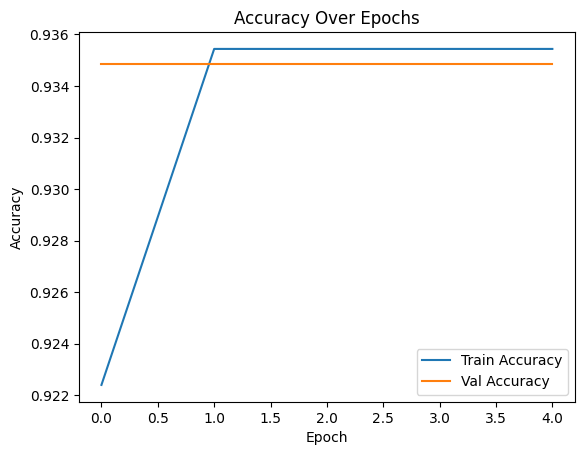

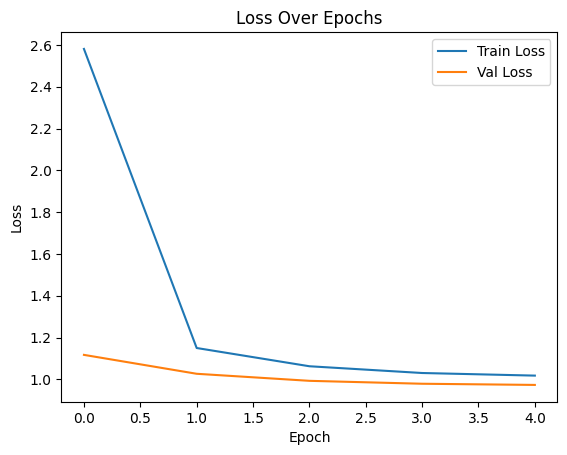

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 11.Making Recommendations
We define a function product_recommender(user_sequence):

- Takes a user’s historical sequence of product IDs.

Pads the sequence.

- Predicts the next product(s) using the trained model.

- Returns the Top-5 recommended products.


In [ ]:
def product_recommender(user_sequence):
    input_seq = pad_sequences([user_sequence], maxlen=max_len - 1, padding="post")
    preds = model.predict(input_seq)
    top_k = preds[0].argsort()[-5:][::-1]
    return product_id_encode.inverse_transform(top_k)


product_recommender([39000, 50000, 20000]) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


array([1000978, 4804056, 1005239, 4804718, 4804295], dtype=int64)

### 12. Sequential model saving 
Finally, we save the trained model for later deployment:

In [ ]:
model.save("sequential_recommendation_system.keras")  

### Convert model to tensorflowlite for easy deployment/production

In [ ]:

from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs, training=False, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,
        })
        return config


model = tf.keras.models.load_model("sequential_Recommendation_system.keras",
                                   custom_objects={"TransformerBlock": TransformerBlock})


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]



tflite_model = converter.convert()

# Save the model
with open("sequential_Recommendation_system.tflite", "wb") as f:
    f.write(tflite_model)


### Part 2 — Content-Based Recommendation Systems

This part implements **content-based recommenders** using BERT embeddings of product metadata.  
We include two variants:

- **2.1 User-based content recommender** : builds user profiles by averaging product embeddings of items a user interacted with, then recommends nearest products by cosine similarity.  
- **2.2 Brand-based content recommender** : creates brand/price embeddings and returns products similar to a given product or brand (with optional category/price filters).



### 2.1 User-based Content Recommender
Create a product text feature (brand + category + normalized price), encode with a pre-trained BERT model to obtain product embeddings, then aggregate those embeddings per user to form user profiles.

In [3]:
from transformers import TFBertModel, BertTokenizer

In [26]:
data1 = data1.sample(frac= 0.1,random_state = rs)

In [27]:
data1 = data1.to_csv("Ecommerce_dataset.csv", index= False)

In [8]:
data1 = pd.read_csv("Ecommerce_dataset.csv")

In [5]:
data1.head(10)

,user_id,product_id,event_type,brand,price,category_code,price_norm,text
0,534813776,1005169,view,samsung,205.43,electronics.smartphone,0.079496,samsung electronics.smartphone price 0.0794963...
1,522037513,6400145,view,intel,34.47,computers.components.cpu,0.013058,intel computers.components.cpu price 0.0130576...
2,552990861,1801881,view,samsung,504.06,electronics.video.tv,0.195550,samsung electronics.video.tv price 0.195550287...
3,515336573,1004949,view,oneplus,874.93,electronics.smartphone,0.339678,oneplus electronics.smartphone price 0.3396782...
4,555901025,12600077,view,vitek,41.16,appliances.kitchen.grill,0.015658,vitek appliances.kitchen.grill price 0.0156575...
5,525983039,1004795,view,xiaomi,220.98,electronics.smartphone,0.085539,xiaomi electronics.smartphone price 0.08553940...
6,572713611,1003317,view,apple,1029.62,electronics.smartphone,0.399794,apple electronics.smartphone price 0.399794030...
7,537516833,1004838,view,oppo,154.39,electronics.smartphone,0.059661,oppo electronics.smartphone price 0.0596611223...
8,568132352,1004856,view,samsung,126.86,electronics.smartphone,0.048962,samsung electronics.smartphone price 0.0489623...
9,512386019,4800585,view,samsung,35.78,electronics.audio.headphone,0.013567,samsung electronics.audio.headphone price 0.01...


**Preprocessing & feature construction**

In [6]:



data1['brand'] = data1['brand'].fillna('unknown')
data1['category_code'] = data1['category_code'].fillna('unknown')


scaler = MinMaxScaler()
data1['price_norm'] = scaler.fit_transform(data1[['price']])

#  combined product text
data1['text'] = data1['brand'] + " " + data1['category_code'] + " price " + data1['price_norm'].astype(str)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

**BERT embedding generation (chunked)**

In [9]:


def get_bert_embeddings(texts, tokenizer, model, batch_size=64, save_path="embeddings_chunk.npy"):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch = [str(x) for x in batch] 

        inputs = tokenizer(batch, padding="max_length", truncation=True, max_length=32, return_tensors="tf")
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        np_embeddings = cls_embeddings.numpy()

        all_embeddings.append(np_embeddings)

        # Save chunk periodically
        if i % (batch_size * 10) == 0:
            print(f"Processed {i}/{len(texts)}")
            np.save(save_path, np.concatenate(all_embeddings, axis=0))

    return tf.convert_to_tensor(np.concatenate(all_embeddings, axis=0))


In [10]:




embeddings = get_bert_embeddings(list(data1['text']), tokenizer, bert_model)




Processed 0/46038
Processed 640/46038
Processed 1280/46038
Processed 1920/46038
Processed 2560/46038
Processed 3200/46038
Processed 3840/46038
Processed 4480/46038
Processed 5120/46038
Processed 5760/46038
Processed 6400/46038
Processed 7040/46038
Processed 7680/46038
Processed 8320/46038
Processed 8960/46038
Processed 9600/46038
Processed 10240/46038
Processed 10880/46038
Processed 11520/46038
Processed 12160/46038
Processed 12800/46038
Processed 13440/46038
Processed 14080/46038
Processed 14720/46038
Processed 15360/46038
Processed 16000/46038
Processed 16640/46038
Processed 17280/46038
Processed 17920/46038
Processed 18560/46038
Processed 19200/46038
Processed 19840/46038
Processed 20480/46038
Processed 21120/46038
Processed 21760/46038
Processed 22400/46038
Processed 23040/46038
Processed 23680/46038
Processed 24320/46038
Processed 24960/46038
Processed 25600/46038
Processed 26240/46038
Processed 26880/46038
Processed 27520/46038
Processed 28160/46038
Processed 28800/46038
Processe

In [11]:
embeddings = tf.convert_to_tensor(np.load('embeddings_chunk.npy'))


**Build user profiles (mean embedding per user)**

In [13]:
from collections import defaultdict
import numpy as np

# Load only completed embeddings
embeddings = tf.convert_to_tensor(np.load('embeddings_chunk.npy'))

# Map only the product_ids that have embeddings
valid_product_ids = data1['product_id'].values[:len(embeddings)]
product_id_to_embedding = {
    pid: emb for pid, emb in zip(valid_product_ids, embeddings.numpy())
}

# Build user profiles safely
user_profiles = defaultdict(list)

for _, row in data1.iterrows():
    pid = row['product_id']
    if pid in product_id_to_embedding: 
        user_profiles[row['user_id']].append(product_id_to_embedding[pid])

# Compute mean embedding for each user
user_id_to_profile = {
    user_id: np.mean(item_embs, axis=0)
    for user_id, item_embs in user_profiles.items()
}


**Recommendation function (user → top-K products)**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_for_user(user_id, top_k):
    if user_id not in user_id_to_profile:
        print("No interaction data for this user.")
        return []

    user_vec = user_id_to_profile[user_id].reshape(1, -1)
    all_item_vecs = embeddings.numpy()

    # Compute cosine similarity
    scores = cosine_similarity(user_vec, all_item_vecs).flatten()

    # Top-K item indices
    top_indices = np.argsort(scores)[::-1][:top_k]

    # Return product_ids
    return data.iloc[top_indices][['product_id', 'brand', 'category_code', 'price', 'text']]


In [ ]:
recommend_for_user(513103710,top_k=5)

,product_id,brand,category_code,price,text
29862,7900194,joie,furniture.kitchen.chair,73.10,NaN
2661,10900336,smeg,appliances.kitchen.mixer,544.53,NaN
1609,1005130,apple,electronics.smartphone,1558.25,NaN
31918,1004777,xiaomi,electronics.smartphone,135.01,NaN
29298,1307478,lenovo,computers.notebook,252.23,NaN


### 2.2 Brand-based Content Recommender
Create brand + price text features, encode with BERT and return items similar to a given product or brand—optionally constrained to same category or a price range.

**Feature construction**

In [14]:
data1['brand_text'] = data1['brand'] + " price " + data1['price_norm'].astype(str)


**Generate brand embeddings (same pattern as above)**

In [15]:
def get_brand_embeddings(texts, tokenizer, model, batch_size=64, save_path="brand_embeddings_chunk.npy"):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch = [str(x) for x in batch] 

        inputs = tokenizer(batch, padding="max_length", truncation=True, max_length=32, return_tensors="tf")
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        np_embeddings = cls_embeddings.numpy()

        all_embeddings.append(np_embeddings)

        # Save chunk periodically
        if i % (batch_size * 10) == 0:
            print(f"Processed {i}/{len(texts)}")
            np.save(save_path, np.concatenate(all_embeddings, axis=0))

    return tf.convert_to_tensor(np.concatenate(all_embeddings, axis=0))

In [16]:
brand_embeddings = get_brand_embeddings(list(data1['brand_text']), tokenizer, bert_model)

Processed 0/46038
Processed 640/46038
Processed 1280/46038
Processed 1920/46038
Processed 2560/46038
Processed 3200/46038
Processed 3840/46038
Processed 4480/46038
Processed 5120/46038
Processed 5760/46038
Processed 6400/46038
Processed 7040/46038
Processed 7680/46038
Processed 8320/46038
Processed 8960/46038
Processed 9600/46038
Processed 10240/46038
Processed 10880/46038
Processed 11520/46038
Processed 12160/46038
Processed 12800/46038
Processed 13440/46038
Processed 14080/46038
Processed 14720/46038
Processed 15360/46038
Processed 16000/46038
Processed 16640/46038
Processed 17280/46038
Processed 17920/46038
Processed 18560/46038
Processed 19200/46038
Processed 19840/46038
Processed 20480/46038
Processed 21120/46038
Processed 21760/46038
Processed 22400/46038
Processed 23040/46038
Processed 23680/46038
Processed 24320/46038
Processed 24960/46038
Processed 25600/46038
Processed 26240/46038
Processed 26880/46038
Processed 27520/46038
Processed 28160/46038
Processed 28800/46038
Processe

**Brand similarity / filtering function**


In [ ]:
def recommend_similar_brand_price_bert(
    product_id=None,
    brand=None,
    top_k= None,
    same_category=True,
    min_price=None,
    max_price=None
):
    if product_id is not None:
        if product_id not in data1['product_id'].values:
            print("Product not found.")
            return []

        idx = data1.index.get_loc(data1.index[data1['product_id'] == product_id][0])
    
    elif brand is not None:
        brand_matches = data1[data1['brand'].str.lower() == brand.lower()]
        if brand_matches.empty:
            print("Brand not found.")
            return []

        rep_row = brand_matches.iloc[0]
        idx = data1.index.get_loc(rep_row.name)
        product_id = rep_row['product_id']
    
    else:
        print("You must provide either a product_id or a brand.")
        return []

    # Get product info
    product = data1.iloc[idx]
    product_vec = brand_embeddings[idx].numpy().reshape(1, -1)

    # Filter the dataset
    filtered_data = data1.copy()
    if same_category:
        filtered_data = filtered_data[filtered_data['category_code'] == product['category_code']]

    # price range filter
    if min_price is not None:
        filtered_data = filtered_data[filtered_data['price'] >= min_price]
    if max_price is not None:
        filtered_data = filtered_data[filtered_data['price'] <= max_price]

 
    filtered_data = filtered_data[filtered_data['product_id'] != product_id]

    # Get filtered indices
    filtered_indices = [data1.index.get_loc(i) for i in filtered_data.index]
    if not filtered_indices:
        print("No similar products found after filtering.")
        return []

    # Compute similarity
    from sklearn.metrics.pairwise import cosine_similarity
    filtered_embeddings = tf.gather(brand_embeddings, filtered_indices)
    similarities = cosine_similarity(product_vec, filtered_embeddings.numpy()).flatten()

    # Get top K
    top_indices = similarities.argsort()[::-1][:top_k]
    top_data_indices = [filtered_data.index[i] for i in top_indices]

    return data1.loc[top_data_indices][['product_id', 'brand', 'category_code', 'price']]





In [19]:
recommend_similar_brand_price_bert( brand = "wincars", top_k=10, max_price= 13) 

,product_id,brand,category_code,price
6650,100005938,trefl,kids.toys,5.12
39124,9002573,abtoys,kids.toys,9.76
4113,9002426,ty,kids.toys,5.77
23859,9002426,ty,kids.toys,5.77
7129,9002426,ty,kids.toys,5.77
18289,8902815,castorland,kids.toys,3.91
28545,9001985,gulliver,kids.toys,10.88
35701,9001985,gulliver,kids.toys,10.88
8275,9001985,gulliver,kids.toys,10.88
32682,9001985,gulliver,kids.toys,10.88


### OVERALL CONCLUSION  

This project successfully demonstrated the design and implementation of a hybrid recommendation system for an e-commerce platform.  

- The **Sequential Recommendation System** captured the temporal patterns of user interactions, enabling accurate next-product predictions.  
- The **Content-Based Systems** (brand-based and user-profile-based) complemented this by recommending products similar in brand, category, or price, improving product discoverability.  
- Together, these systems provided a **multi-layered recommendation pipeline** that balances personalization, diversity, and relevance.  
